# Предсказание погоды с использованием временных рядов.
Задача: строить прогнозы погоды на основе исторических метеорологических данных.

## Загрузка датасета

In [227]:
# Импорт библиотек
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Выгрузка данных из таблицы с тренировочными данными
train_data: np.ndarray = pd.read_csv("CSV/DailyDelhiClimateTrain.csv").values

# Выгрузка данных из таблицы с тестовыми данными
test_data: np.ndarray = pd.read_csv("CSV/DailyDelhiClimateTest.csv").values

print(train_data)

[['2013-01-01' 10.0 84.5 0.0 1015.6666666666666]
 ['2013-01-02' 7.4 92.0 2.98 1017.8]
 ['2013-01-03' 7.166666666666667 87.0 4.633333333333334
  1018.6666666666666]
 ...
 ['2016-12-30' 14.095238095238097 89.66666666666667 6.266666666666667
  1017.904761904762]
 ['2016-12-31' 15.052631578947368 87.0 7.325 1016.1]
 ['2017-01-01' 10.0 100.0 0.0 1016.0]]


## Нормализация данных

Естественно, ни одна модель не сможет понять, что значит строковое представление даты "2017-01-01",  
так что давайте приведем значения первого столбца к целым числам (кол-во дней с начала отсчета)

Функция перевода даты в кол-во дней от 2013-01-01 (самая первая дата в таблице):

In [228]:
def days_since_zero_date(date_str: str) -> int:
	# Преобразование строки в объект datetime
	date_format: str = "%Y-%m-%d"
	date_obj = datetime.strptime(date_str, date_format)
	
	# Нулевая дата
	zero_date = datetime.strptime("2013-01-01", date_format)
	
	# Вычисление разницы в днях
	delta = date_obj - zero_date
	days = delta.days
	 
	return days

Теперь переведем все даты в загруженных таблицах в дни и выведем результат:

In [229]:
# Применяем ранее определенную функцию ко всем датам датасета
train_data[:, 0] = np.vectorize(days_since_zero_date)(train_data[:, 0])
test_data[:, 0] = np.vectorize(days_since_zero_date)(test_data[:, 0])

train_data = train_data.astype("float")
test_data = test_data.astype("float")

print(train_data[0])
# Вывод - [0 10.0 84.5 0.0 1015.6666666666666]
# Видно, что все даты превратились в дни

[   0.           10.           84.5           0.         1015.66666667]


Далее необходимо нормализовать данные. Нормализовывать данные будем по методу Z-Нормализации. 

![Z-normalize](assets/Z-normalize.png)

Где:  
  
- **X с чертой** - среднее значение выборки

- **Сигма {x}** - стандартное отклонение выборки

- **x{i}** - ненормализованное значение

- **x{i}'** - нормализованное значение

In [230]:
class Normalize:
	def __init__(self, data: np.ndarray) -> None:
		self.data: np.ndarray = np.copy(data) # Записываем копию данных
		
		# Вычисляем среднее по каждому столбцу
		self.__mean: np.ndarray = data.mean(axis=0)
		# Вычисляем стандартное отклонение по каждому столбцу
		self.__std_dev: np.ndarray = data.std(axis=0)
		
	def normalizeData(self) -> np.ndarray:
		# Возврат нормализованных даннах по формуле
		return (self.data - self.__mean) / self.__std_dev
		
	def DeNormalizeData(
		self, normalized_data: np.ndarray, axes: list[int] = [0, 1, 2, 3]
	) -> np.ndarray:
		# Денормализация днанных по указанной оси
		return normalized_data * self.__std_dev[axes] + self.__mean[axes]

# Нормализация погодных данных
train_normalize_class = Normalize(train_data[:, 1:])
train_data[:, 1:] = train_normalize_class.normalizeData()

В данном фрагменте был создан класс, реализующий логику нормализации данных. 
В двух последних строках нормализовали обучающую выборку (кроме значений дней).
Метод DeNormalizeData позволяет интерпретировать любые данные, полученные с помощью модели, в привычной нам форме.

Построим график температуры для наглядности.

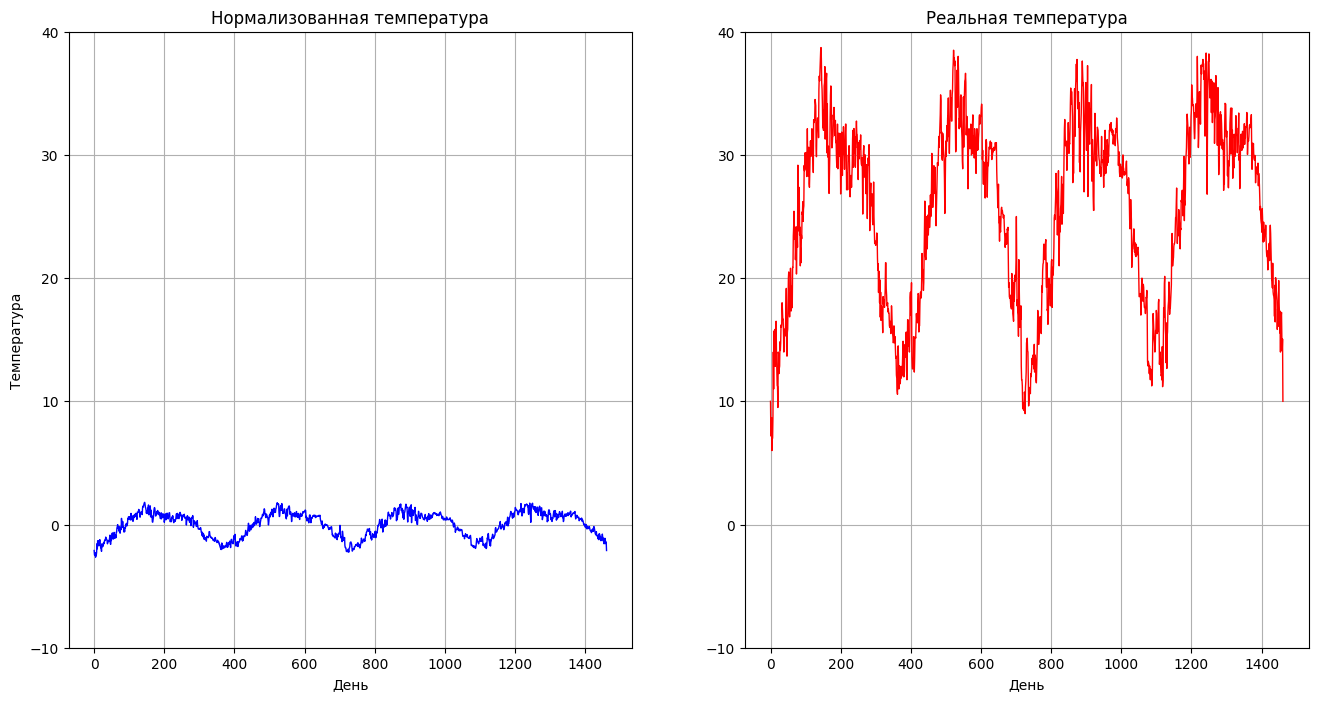

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Лимиты для осей
ax[0].set_ylim([-10, 40])
ax[1].set_ylim([-10, 40])

# Подписи осей
ax[0].set_ylabel("Температура")
ax[0].set_xlabel("День")
ax[1].set_xlabel("День")

ax[0].set_title("Нормализованная температура")
ax[1].set_title("Реальная температура")

# Сетка на осях
ax[0].grid()
ax[1].grid()

# Отображение нормализованных и ненормализованных данных на примере температуры
ax[0].plot(train_data[:, 1], c='b', linewidth=1)
ax[1].plot(
    train_normalize_class.DeNormalizeData(train_data[:, 1], axes=0),
    c='r',
    linewidth=1
)

plt.show()

Поскольку наша временная модель имеет в своих параметрах значения, обозначающие вероятность,  
нам необходима нормализация данных для ограничения входного значения между (-1..1).  
Такие данные будут более удобны для анализа регрессионноя моделью

## Сглаживание шума

Сглаживать шум будем методом скользящей средней. Суть метода в том, что мы проходимся по всему графику "окном" определенного размера. Перемещая окно, вычисляем среднее всех значений, которые в него попали. Таким образом мы сглаживаем весь шум графика, так как он компенсирует сам себя. 

![SMA](assets/SMA.png)

**SMA{t}** - значение простого скользящего среднего в точке **t**  
  
**n** - количество значений исходной функции для расчёта скользящего среднего (размер "окна")  
  
**p{t-i}** - значение исходной функции в точке **t-i**

1442 1462 20


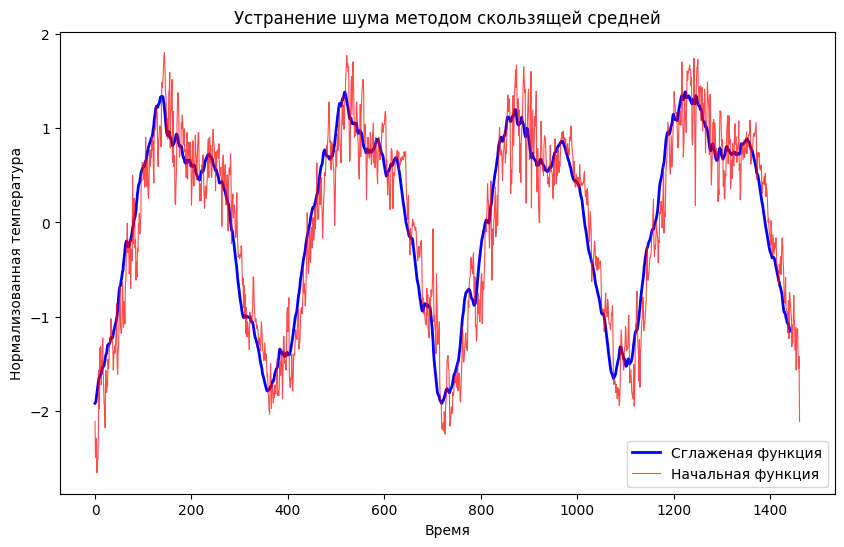

In [232]:
def SMA(data, window=10):
	sma_values = np.zeros(len(data) - window)
	print(len(sma_values), data.shape[0], window)
	l = window // 2
	r = (window + 1) // 2
	denoised_index = 0

	for i in range(data.shape[0]):
		# if l <= i < data.shape[0] - r:
		# 	sma_values[denoised_index] = np.mean(data[i - l: i + r])
		# 	denoised_index+= 1
		if i < data.shape[0] - window:
			sma_values[denoised_index] = np.mean(data[denoised_index:denoised_index + window])
			denoised_index+= 1
	return sma_values

window_size = train_data.shape[0] // 70
denoised_data = SMA(pd.Series(train_data[:, 1]), window_size)

fig = plt.figure(figsize=(10, 6))
plt.plot(denoised_data, label="Сглаженая функция", c='b', linewidth=2.0)
plt.plot(train_data[:, 1], label="Начальная функция", c='r', alpha=0.7, linewidth=0.8)

plt.title("Устранение шума методом скользящей средней")
plt.ylabel("Нормализованная температура")
plt.xlabel("Время")
plt.legend()

plt.show()

## Прогнозирование данных

Видно, что график температуры обладает ярко выраженной периодичностью и сильно напоминает синусоиду.
Из этого вытекает цель - подобрать наиболее подходящую синусоиду (или сумму синусоид), которая будет наилучшим образом соответствовать температуре.

Подбор подходящей кривой с помощью преобразования Фурье и градиентного спуска.

### Подбор подходящей кривой с помощью преобразования Фурье и градиентного спуска.

Преобразование Фурье - операция, которая сопоставляет первой функции вторую: вторая функция описывает коэффициенты («амплитуды») при разложении первой функции на элементарные составляющие — гармонические колебания с разными частотами. То есть фактически данное преобразование раскладывает функцию на сумму синусов разной частоты.

Формально преобразование определяется так:

![furry](assets/furry.png)

Таким образом, если мы возьмем несколько синусоид максимальной амплитуды (те, которые лучше всего аппроксимируют наши данные) и построим график их суммы, то мы получим неплохую аппроксимацию температуры (в нашем случае).

Но, к сожалению, преобразование Фурье не выдает нам все веса идеальной функции, но и нам нужна только частота, ведь остальные параметры мы получим с помощью метода градиентного спуска.

In [233]:
# Значения на оси X (абсциссе), на основе которых модель будет делать предсказания
x_data: np.ndarray = np.linspace(0, len(denoised_data), len(denoised_data))

# Дискретное Преобразование Фурье, список амплитуд
mfft: np.ndarray = np.fft.fft(denoised_data)

# Получаем индексы частот, которые соответствуют самым значимым (с высокой амплитудой) синусоидам.
imax: np.ndarray = np.argsort(np.absolute(mfft))[::-1]


Для простоты мы будем раскладывать наши данные на сумму 5 синусоид.  
Не будем брать слишком много слагаемых, чтобы модель не потеряла обобщающую способность.

In [234]:
# Кол-во синусов, которые мы будем суммировать
number_of_sinuses: int = 25

# Берем первые number_of_sinuses самых высоких амплитуд (они соответствуют частотам)
imax = imax[:number_of_sinuses]

# Вычисляем частоту каждой синусоиды
frequency:np.ndarray = np.array(imax) / len(denoised_data)

print(frequency)

[2.77392510e-03 9.97226075e-01 5.54785021e-03 9.94452150e-01
 6.93481276e-04 9.99306519e-01 1.38696255e-03 9.98613037e-01
 2.08044383e-03 9.97919556e-01 9.91678225e-01 8.32177531e-03
 9.95145631e-01 4.85436893e-03 9.93758669e-01 6.24133148e-03
 9.88904300e-01 1.10957004e-02 6.93481276e-03 9.93065187e-01
 0.00000000e+00 9.70873786e-03 9.90291262e-01 7.62829404e-03
 9.92371706e-01]


### Оптимизация параметров
Для начала определим функцию, которая будет аппроксимировать наши данные о температуре.  
Из-за того, что мы рассматриваем сумму 5 синусов:

![sinus_sum](assets/sinus_sum.png)

Теперь нужно инициализировать наши параметры так, чтобы их получилось верно оптимизировать (большинство моделей плохо оптимизируют параметры тригонометрических функций со случайно инициализированной частотой).

1. Параметр **w{3i}** будем инициализировать значением стандартного отклонения всей выборки (**w{3i}** = **Сигма {x}**).
  
2. Параметр **w{3i+1}** (самый важный) будем инициализировать полученной частотой (умноженной на **2\pi**) для каждого синуса соответственно (**w{3i+1}** = **2\pi * f{i}**). Это нужно сделать, чтобы модель не подбирала частоту волны, в противном случае параметры не будут оптимизированы.
  
3. Параметр сдвига по абсциссе мы инициализируем **-np.pi/2**
  
4. Параметр b мы инициализируем математическим ожиданием выборки (**b** = **X с чертой**)

In [235]:
# Начальные параметры
init_params: np.ndarray = np.array(
	[
		np.array([np.std(denoised_data), frequency[i] * 2 * np.pi, 0])
		for i in range(number_of_sinuses)
	]
)

bias: float = np.mean(denoised_data)


### Функция ошибки (MSE)

В качестве функции ошибки модели используем функция ошибки MSE, которую наш алгоритм будет пытаться минимизировать  
  
![MSE](assets/MSE.png)  

Где:
    
- **y** - реальное значение целевой переменной (метка)  
  
- **y с чертой** - предсказание модели



### Градиентный спуск
Градиентный спуск заключается в том, что по мере обучения модели мы вычитаем из каждого веса значение его локальной частной производной от функции ошибки.  
Данный алгоритм приводит к ее минимизации, то есть к наиболее точным ответам модели.  
  
![gradient](assets/gradient.png)  
  
Где:  
  
- **E** - функция ошибки
  
- **w{n}** - данный вес
  
- **η** - коэффициент скорости обучения (чем больше, тем агрессивнее обучается модель, часто выбирают 10^{-3})

Поскольку нам сразу известна формула, по которой будет проходить апроксимация данных, нам будет очень полезно найти формулы градиентов по каждому из весов:  
Общая формула градиента:
  
![gradient_general](assets/gradient_general.png)  
  
1. Градиент по амплитуде **ω{3i}**
  
![​gradient_formula1](assets/gradient_formula1.png)  
  
2. Градиент по частоте **ω{3i+1}**  
  
![​gradient_formula2](assets/​gradient_formula2.png)  
​  
3. Градиент по фазе **ω{3i+2}**   
  
![​gradient_formula3](assets/​gradient_formula3.png)  
  
4. Градиент по смещению **b**  
  
![​gradient_formula4](assets/​gradient_formula4.png)

### Оптимизатор Adam

Оптимизируем наши параметры путем градиентного спуска в связке с оптимизатором Adam.  
Идея Adam заключается в том, чтобы адаптивно изменять скорость обучения для каждого веса на основе двух моментов первого и второго порядков градиента.  
Веса с большим градиентом получают меньший шаг, а веса с меньшим градиентом получают больший шаг.  
  
Оптимизатор работает по данному алгоритму:  
  
![ADAM_elements](assets/ADAM_elements.png)
  
Оптимизация весов:  
  
![ADAM](assets/ADAM.png)  
  
Где:  
  
- **t** - номер итерации
  
- **w{t}** - вектор весов в момент времени **t**
  
- **g{t}** - вектор градиентов в момент времени **t**
  
- **m{t}** - оценка первого момента (среднего значения) градиента в момент времени **t**
  
- **v{t}** - оценка второго момента (среднего квадрата) градиента в момент времени **t**
  
- **β1** и **β2** - параметры, обычно равные 0.9 и 0.999 соответственно
  
- **η** - скорость обучения
  
- **ε** - малое число, используемое для стабилизации деления

### Специфика архитектуры Регрессионной Модели

Если бы мы моделировали распознавание цифр на изображении, скрытые слои были бы необходимы, чтобы выявлять края, углы и другие признаки.  
Но для циклических данных, где зависимость от времени t уже задана синусоидами, дополнительные слои только усложнят модель без выигрыша в точности.  
Поэтому наша модель будет состоять только из входного и выходного слоя
  
Также в классических сетях функции ставятся активации (ReLU, sigmoid) после каждого слоя, чтобы модель могла аппроксимировать произвольные функции. В нашем случае нелинейность уже заложена в структуру модели через синусы, поэтому дополнительные активации избыточны.

## Создание Регрессионной Модели

Напишем функцию, которая будет подсчитывать отдельные параметры выходного слоя

In [236]:
def forward(parameters: np.ndarray, bias: float, time: np.ndarray) -> float:
    y_predicted = np.full_like(time, bias)     # Создаем вектор размером с time заполненый bias
    for i in range(parameters.shape[0]):
        A = parameters[i, 0]
        omega = parameters[i, 1]
        phi = parameters[i, 2]
        y_predicted+= A * np.sin(omega * time + phi)    # Сумма пяти синусоид
    return y_predicted

Напишем функцию потерь для последующего обучения регрессионной модели, путем уменьшения её значения

In [237]:
def mse_loss(y_predicted: np.ndarray, y_true: np.ndarray) -> float:
    return np.mean((y_predicted - y_true) ** 2)

Напишем функцию подсчета градиента для подсчета скорости роста функции при данных параметров

In [238]:
def get_gradients(parameters: np.ndarray, bias: float, time: np.ndarray, y_true: np.ndarray) -> [np.ndarray, float]:
    n = len(time)
    y_predicted = forward(parameters, bias, time)
    error = y_predicted - y_true        # Подсчитываем вектор ошибки, который встречается у всех формул градиентов

    gradient_parameters = np.zeros_like(parameters)
    for i in range(parameters.shape[0]):

        A = parameters[i, 0]
        omega = parameters[i, 1]
        phi = parameters[i, 2]

        trigonometric_arguments = omega * time + phi    # Подсчитываем вектор триганометрического аргумента

        gradient_parameters[i, 0] = (2/n) * np.sum(error * np.sin(trigonometric_arguments))             # dE/dA
        gradient_parameters[i, 1] = (2/n) * np.sum(error * A * time * np.cos(trigonometric_arguments))  # dE/dω
        gradient_parameters[i, 2] = (2/n) * np.sum(error * A * np.cos(trigonometric_arguments))         # dE/dφ
    
    gradient_bias = (2/n) * np.sum(error)

    return gradient_parameters, gradient_bias

Напишем оптимизатор ADAM для корректирования параметров

In [239]:
class AdamOptimizer: 
    def __init__(self, parameters_shape: tuple, speed: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-8):
        self.speed = speed
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.iteration_step = 0

        # Моменты для параметров
        self.m_parameters = np.zeros(parameters_shape)  
        self.v_parameters = np.zeros(parameters_shape)

        # Моменты для смещения
        self.m_bias = 0.0              
        self.v_bias = 0.0

    def step(self, parameters: np.ndarray, bias: float, gradien_parameters: np.ndarray, gradien_bias: float) -> tuple:
        self.iteration_step += 1
        
        # Обновление моментов для параметров (A, ω, φ)
        self.m_parameters = self.beta1 * self.m_parameters + (1 - self.beta1) * gradien_parameters
        self.v_parameters = self.beta2 * self.v_parameters + (1 - self.beta2) * (gradien_parameters ** 2)

        # Коррекция смещения моментов
        m_hat_parameters = self.m_parameters / (1 - self.beta1 ** self.iteration_step)
        v_hat_parameters = self.v_parameters / (1 - self.beta2 ** self.iteration_step)

        # Обновление параметров
        parameters -= self.speed * m_hat_parameters / (np.sqrt(v_hat_parameters) + self.epsilon)

        # Обновление моментов для смещения (b)
        self.m_bias = self.beta1 * self.m_bias + (1 - self.beta1) * gradien_bias
        self.v_bias = self.beta2 * self.v_bias + (1 - self.beta2) * (gradien_bias ** 2)

        # Коррекция смещения для bias
        m_hat_bias = self.m_bias / (1 - self.beta1 ** self.iteration_step)
        v_hat_bias = self.v_bias / (1 - self.beta2 ** self.iteration_step)

        # Обновление смещения
        bias -= self.speed * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)

        return parameters, bias

Реализуем функцию, которая подберет подходящие параметры для данной модели. Также подсчитаем значения функции потерь на определенных эпохах.  
Правилом хорошего тона будет добавление к ответу регрессионной модели случайного шума 

In [247]:
def train(parameters: np.ndarray, bias: float, time: np.ndarray, y_true: np.ndarray, epochs: int = 1000, speed: float = 0.001) -> [np.ndarray, float]:
    # Инициализация оптимизатора
    optimizer = AdamOptimizer(parameters_shape=parameters.shape, speed=speed)

    for epoch in range(epochs):
        # Расчет градиентов
        grad_params, grad_bias = get_gradients(parameters, bias, time, y_true)

        # Обновление параметров
        parameters, bias = optimizer.step(parameters, bias, grad_params, grad_bias)

        # Логирование
        if epoch % 100 == 0:
            loss = mse_loss(forward(parameters, bias, time),  y_true)
            print(f"Epoch {epoch}: Loss = {loss:.4f}")      
    return parameters, bias


# Гиперпараметры
epochs = 3000
learning_rate = 0.001
noise_std = 0.1     # Генерация шумов (стандартное отклонение)

# Генерация зашумленных данных на основе стандартного отклонения
noise = np.random.normal(0, 0.1, denoised_data.shape)
y_train_noisy = denoised_data + noise

# Обучение
params = init_params.copy()
current_bias = bias

params, current_bias = train(params, current_bias, x_data, y_train_noisy, epochs, learning_rate)

# Предсказание + добавление шума
predictions = forward(params, current_bias, x_data)
predictions_noisy = predictions + np.random.normal(0, noise_std, predictions.shape)


Epoch 0: Loss = 10.5348
Epoch 100: Loss = 1.0679
Epoch 200: Loss = 0.7835
Epoch 300: Loss = 0.5830
Epoch 400: Loss = 0.4410
Epoch 500: Loss = 0.3387
Epoch 600: Loss = 0.2618
Epoch 700: Loss = 0.2221
Epoch 800: Loss = 0.2026
Epoch 900: Loss = 0.1269
Epoch 1000: Loss = 0.1188
Epoch 1100: Loss = 0.0831
Epoch 1200: Loss = 0.0870
Epoch 1300: Loss = 0.0626
Epoch 1400: Loss = 0.2869
Epoch 1500: Loss = 0.0412
Epoch 1600: Loss = 0.0358
Epoch 1700: Loss = 0.0324
Epoch 1800: Loss = 0.0326
Epoch 1900: Loss = 0.0293
Epoch 2000: Loss = 0.0284
Epoch 2100: Loss = 0.0285
Epoch 2200: Loss = 0.0275
Epoch 2300: Loss = 0.0265
Epoch 2400: Loss = 0.0391
Epoch 2500: Loss = 0.0268
Epoch 2600: Loss = 0.0271
Epoch 2700: Loss = 0.0260
Epoch 2800: Loss = 0.0257
Epoch 2900: Loss = 0.0254


Ознакомимся с результатом нашей модели. Проверим как предсказанные значения моделью будут коррелировать с сглаженной функцией и заготовленными ранее тренировочными данными.  
Для вычисления ошибки модели будем использовать функцию MAE  
  
![MAE](assets/MAE.png)

In [257]:
def mae_loss(y_predicted: np.ndarray, y_true: np.ndarray) -> float:
    return np.mean(np.abs(y_predicted - y_true))

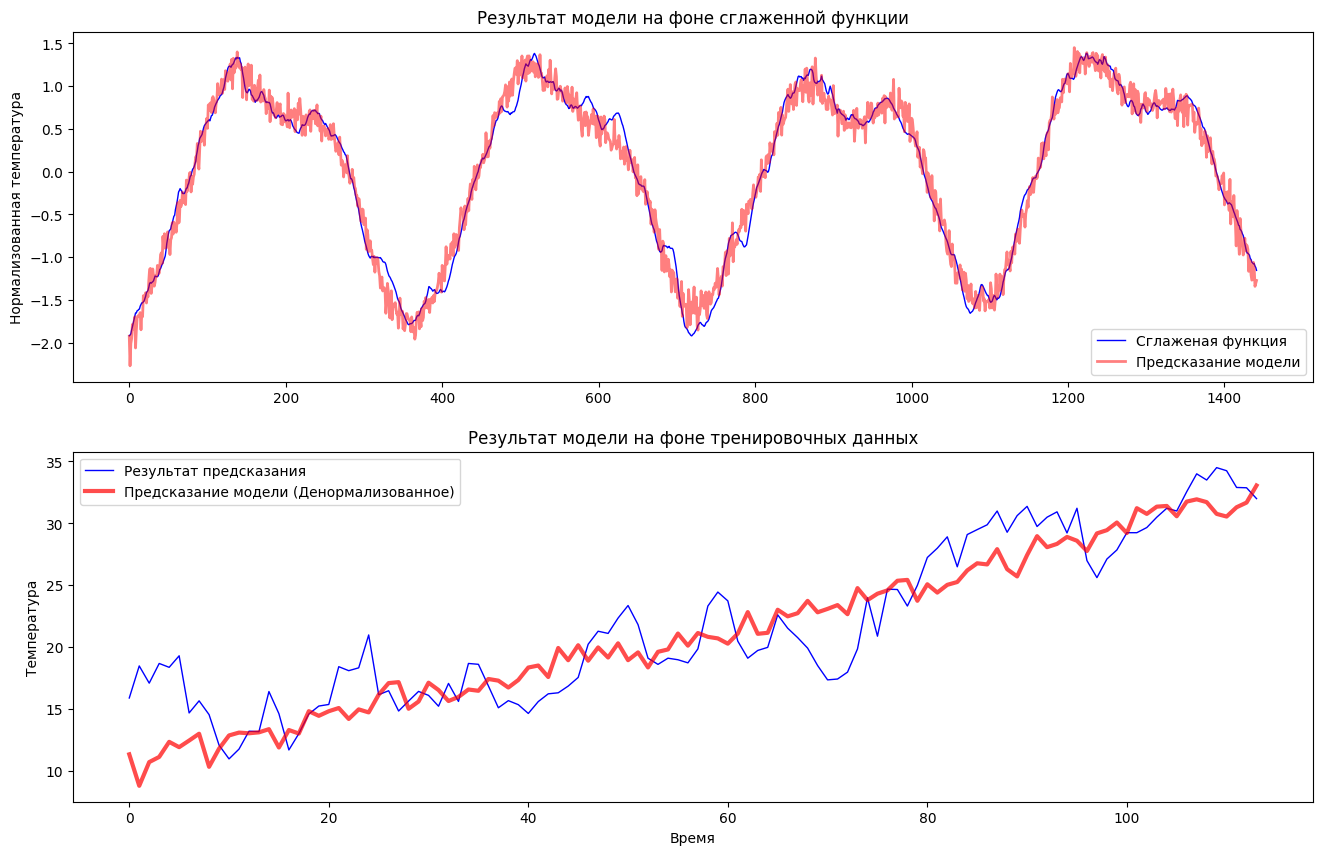

2.3253683963305045


In [258]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(denoised_data, label="Сглаженая функция", c='b', linewidth=1.0)
plt.plot(predictions_noisy, label="Предсказание модели", c='r', alpha=0.5, linewidth=2.0)

plt.title("Результат модели на фоне сглаженной функции")
plt.ylabel("Нормализованная температура")
plt.legend()

plt.subplot(212)
plt.plot(test_data[:, 1], label="Результат предсказания ", c='b', linewidth=1.0)
denormalized_predictions = train_normalize_class.DeNormalizeData(predictions_noisy, axes=[0])[:test_data.shape[0]]
plt.plot(denormalized_predictions, label="Предсказание модели (Денормализованное)", c='r', alpha=0.7, linewidth=3.0)

plt.title("Результат модели на фоне тренировочных данных")
plt.ylabel("Температура")
plt.xlabel("Время")
plt.legend()

plt.show()
print(mae_loss(denormalized_predictions, test_data[:, 1]))

Важно заметить, что данная модель - лишь пример, который был приведен в целях указать на возможные способы поиска периодизации и трендов в данных. Если у вас есть структурированные данные, не такие сложные как погода, то описанный в статье метод может оказаться более чем эффективным. Но в случае с погодой, естественно, правильным будет обращаться за помощью к метеорологической службе.